# 1-0. Import

In [1]:
import os.path as osp
import openslide
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.filters import threshold_otsu

from openslide.deepzoom import DeepZoomGenerator

import cv2
from keras.utils.np_utils import to_categorical

# network

from keras import layers, models
from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

# train

from sklearn.model_selection import StratifiedShuffleSplit
from datetime import datetime

# evaluate

import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import math
from PIL import Image
from xml.etree.ElementTree import ElementTree, Element, SubElement
from io import BytesIO


from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import keras.backend.tensorflow_backend as K

Using TensorFlow backend.


# 1-1. Data Load

In [2]:
slide_path = '../data/train/pos/16-S-042893_A1.mrxs'  # pos
#slide = openslide.open_slide(slide_path)

BASE_TRUTH_DIR = Path('../data/train')
truth_path = str(BASE_TRUTH_DIR/'pos/Mask_16-S-042893_A1.png')
#truth = openslide.open_slide(truth_path)

#print("original slide dimensions %dx%d" % slide.dimensions)
#print("original truth dimensions %dx%d" % truth.dimensions)

# 1-2. Fit Data Shape

- 밑에 a, b 괄호친 부분은 csv 파일 읽고 min_x, min_y 넣어야함 (이게 사실 필요가 없음)

- https://openslide.org/api/python/#module-openslide

- 이부분은 opensilde_test.ipynb 파일에 실험한 것 참고


## Check if works

In [3]:

# f, axes = plt.subplots(1, 2, figsize=(20, 10));
# ax = axes.ravel()
# ax[0].imshow(slide4);
# ax[0].set_title('Slide %dx%d' % slide4.size)
# ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
# ax[1].set_title('Truth %dx%d' % thumbnail_truth.size)
# f.suptitle('Slide & Truth Thumbnails ');

# 1-3 Patch Gen

- get_thumbnail(size)
: Return an Image containing an RGB thumbnail of the slide.
- patch size 만큼 dimensions 나누기. 1 픽셀이 하나의 패치가 됨 -> DeepZoomGenerator로 다시 확대가능 (patch_size만큼) (2의 거듭제곱으로)
- tissue 검사 - patch['is_tissue'] : ostu method
- tumor 검사 - patch['is_tummor'] 라벨 : mask로 구분
- 경로 추가 저장 = patch['slide_path']
- 최종 training set = concat[patch, patch_y]

In [4]:
PATCH_SIZE = 256
IS_TRAIN = True
def find_patches_from_slide(slide_path, base_truth_dir=BASE_TRUTH_DIR,patch_size=PATCH_SIZE,filter_non_tissue=True):
    """Returns a dataframe of all patches in slide
    input: slide_path: path to WSI file
    output: samples: dataframe with the following columns:
        slide_path: path of slide
        is_tissue: sample contains tissue
        is_tumor: truth status of sample
        tile_loc: coordinates of samples in slide
        
    
    option: base_truth_dir: directory of truth slides
    option: filter_non_tissue: Remove samples no tissue detected
    option: patch_size: patch_size
    slide_contains_tumor true -> taking the label from mask png
    """
    slide_contains_tumor = 'pos' in slide_path
   

    truth_path = str(BASE_TRUTH_DIR/'pos/Mask_16-S-042893_A1.png') # 이부분도 slide에서 불러들여서 자동으로 읽는걸로 바꾸고
    #truth = openslide.open_slide(truth_path)
    
    ############### read_region을 위한 start, level, size를 구함 #######################
    BOUNDS_OFFSET_PROPS = (openslide.PROPERTY_NAME_BOUNDS_X, openslide.PROPERTY_NAME_BOUNDS_Y)
    BOUNDS_SIZE_PROPS = (openslide.PROPERTY_NAME_BOUNDS_WIDTH, openslide.PROPERTY_NAME_BOUNDS_HEIGHT)
    
    with openslide.open_slide(slide_path) as slide:
        start = (int(slide.properties.get('openslide.bounds-x',0)),int(slide.properties.get('openslide.bounds-y',0))) # BOUNDS_OFFSET_PROPS
        level = np.log2(patch_size) # 되도록 레벨은 2의 거듭제곱으로 설정하자
        level = int(level)
        
        size_scale = tuple(int(slide.properties.get(prop, l0_lim)) / l0_lim
                        for prop, l0_lim in zip(BOUNDS_SIZE_PROPS,
                        slide.dimensions))
        _l_dimensions = tuple(tuple(int(math.ceil(l_lim * scale))
                        for l_lim, scale in zip(l_size, size_scale))
                        for l_size in slide.level_dimensions)
        size = _l_dimensions[level]
        
        slide4 = slide.read_region(start,level,size) # 3초 #read_region(location, level, size)
    
    #slide = openslide.open_slide(slide_path)
    ####################################################################################
    
    
    # is_tissue 부분 
    slide4_grey = np.array(slide4.convert('L'))
    binary = slide4_grey > 0  # black이면 0임
    
    # 검은색 제외하고 흰색영역(배경이라고 여겨지는)에 대해서도 작업해주어야함.
    slide4_not_black = slide4_grey[slide4_grey>0]
    thresh = threshold_otsu(slide4_not_black)
    
    I, J = slide4_grey.shape
    for i in range(I):
        for j in range(J):
            if slide4_grey[i,j] > thresh :
                binary[i,j] = False
    patches = pd.DataFrame(pd.DataFrame(binary).stack())
    patches['is_tissue'] = patches[0]
    patches.drop(0, axis=1,inplace =True)
    patches['slide_path'] = slide_path

    # is_tumor 부분
    if slide_contains_tumor:
        with openslide.open_slide(truth_path) as truth:
            thumbnail_truth = truth.get_thumbnail(size) 
        
        patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        
        # mask된 영역이 애매할 수도 있으므로
        patches_y['is_all_tumor'] = patches_y[0] == 255
        patches_y.drop(0, axis=1, inplace=True)
        samples = pd.concat([patches, patches_y], axis=1) #len(samples)
    else:
        samples = patches
        samples['is_tumor'] = False
    
    if filter_non_tissue:
        samples = samples[samples.is_tissue == True] # remove patches with no tissue #samples = samples[samples.is_tissue == True]
    
    filter_only_all_tumor = True
        
    samples['tile_loc'] = list(samples.index)
    all_tissue_samples1 = samples[samples.is_tumor==False]
    all_tissue_samples1 = all_tissue_samples1.append(samples[samples.is_all_tumor==True])
    
    all_tissue_samples1.reset_index(inplace=True, drop=True)
    
    return all_tissue_samples1

In [5]:
all_tissue_samples = find_patches_from_slide(slide_path)
print('Total patches in slide: %d' % len(all_tissue_samples)) 
all_tissue_samples.iloc[:10]
all_tissue_samples.is_tumor.value_counts() 

#3초만에 뽑음

Total patches in slide: 105213


False    74490
True     30723
Name: is_tumor, dtype: int64

In [6]:
all_tissue_samples.head(3)

,is_tissue,slide_path,is_tumor,is_all_tumor,tile_loc
0,True,../data/train/pos/16-S-042893_A1.mrxs,False,False,"(17, 165)"
1,True,../data/train/pos/16-S-042893_A1.mrxs,False,False,"(17, 166)"
2,True,../data/train/pos/16-S-042893_A1.mrxs,False,False,"(17, 167)"


In [7]:
# len(all_tissue_samples[all_tissue_samples.is_tumor==False]) # 74490
# len(all_tissue_samples[all_tissue_samples.is_all_tumor==True]) # 30723
# all_tissue_samples1 = all_tissue_samples[all_tissue_samples.is_tumor==False]
# all_tissue_samples1 = all_tissue_samples1.append(all_tissue_samples[all_tissue_samples.is_all_tumor==True])
# all_tissue_samples1.is_tumor.value_counts() # 애매한 4천개 줄음
# '''
# False    74490
# True     30723
# Name: is_tumor, dtype: int64
# '''

# check the is_tissue part

- 원래 이미지를 convert하면 흰색(배경)이미지는 255로 높은 값을 가지게 됨
- otsu라는 method를 통해서 threshold(이 이상부터는 배경값이라고 여길 수 있는)를 얻고
- 이 threshold(아래 변수에서는 thresh)보다 크면 배경, 아니면 배경 아님
- 그런데 slide에서 slide4를 convert하면 대부분의 배경색이 자체적으로 검은색으로 칠해진것을 확인할 수 있었음
- 따라서 다음과 같이 is_tissue를 판별해줌
    - 1. 일단 grey로 convert후, 0보다 크면 True 아니면 False (검은색 부분 처리)
    - 2. black이 아닌 남은 값들로 otsu method를 통해 threshold 계산 후 배경부분 처리(흰색 부분 처리)

In [8]:
# slide4
# slide4_grey = np.array(slide4.convert('L'))
# slide4.convert('L')
# slide4_grey.shape # (625, 332)
# thresh = threshold_otsu(slide4_grey)
# binary = slide4_grey > thresh
# binary.shape # (625, 332)
# slide4_not_black = slide4_grey[slide4_grey>0]
# thresh = threshold_otsu(slide4_not_black)
# thresh # 186
# type(slide4_grey)
# binary = slide4_grey > 0
# slide4_grey[0,0]

In [9]:
# 아래 코드로 패치들중에 배경이 많이 들어간 것을 확인할 수 있었음
# from PIL import Image
# im = Image.fromarray(np.uint8(example_X[26]))
# thresh = threshold_otsu(np.array(im.convert('L')))
# print(thresh) # 6 : 251 10 ; 249 17 : 251 14: 154 23: 152, 24: 190, 25 : 182 28 : 249 30: 123 39 : 195 58 : 162 #180이상은 다시 tissue 아님
# np.max(example_X[1])
# im = Image.fromarray(np.uint8(example_X[6]))
# im.convert('L') # 원래는 이렇게 돼야 정상인데
# np.max(example_X[1])
# im = Image.fromarray(np.uint8(example_X[0]))
# thresh = threshold_otsu(np.array(im.convert('L')))
# binary = np.array(im.convert('L')) > thresh

## Check if works - slide_tile_loc, 

- tile(slide에서 뽑은 패치)와 tile_truth(mask_patch) 간의 매칭이 되지 않아 아래 작업 수행 알게된 사실은 다음 3가지
    - 1. tiles의 shape은 (256, 256) , tiles_truth의 shape은 (16,16) (하지만 truth는 이미 원본 최고레벨 슬라이드의 1/16이므로 이렇게 맞춰줘야 같은 영역을 매칭
    - 2. get_tile 할때는 x,y바꿔서 넣어줘야함
    - 3. tiles의 타일 사이즈 (368, 915) tiles_truth의 타일 사이즈 (333,626) 으로 위에서 thumbnail 얻었을 때보다 x,y가 1씩 큼 그래서 끝부분 확인
    - 4. slide의 타일과  바로 가져오려면 min_offset 고려해서 가져와야함. start / patch_size 만큼 더해줘야함 

In [10]:
# start #(7744, 39056)
# tiles = DeepZoomGenerator(slide,tile_size=256, overlap=0 ,limit_bounds = False)
# tiles_truth = DeepZoomGenerator(truth, tile_size=16, overlap = 0, limit_bounds = False)
# print('tile, truth level # : ',tiles.level_count,
# tiles_truth.level_count) # tile, truth level # :  19 15
# tiles.level_dimensions[18] # (93970, 234042)
# tiles.tile_count # 끝에 잘리는부분도 하나로 만듬 (각 영역이 추가됨)
# tiles_truth.level_tiles[14] # tiles.level_tiles[18]
# tiles.level_tiles[18] # (368, 915)
# tiles.level_dimensions[10] #(368, 915)
# tiles_truth.level_dimensions[10] # (333, 626)
# samples[samples.is_tumor>0].head(5)  # is_tumor > 0 확인
# thumbnail_truth.size # (332, 625) thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / truth_div, truth.dimensions[1] / truth_div))
# k = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
# k['tile_loc'] = list(k.index)
# k.reset_index(inplace=True, drop=True) # tile_loc 은 x,y가 거꾸로 들어감 (height, width) 정보라고 보면됨 (y,x)로 들어감
# k = k[k[0]>0]
# k


In [11]:
# visual 
# f, axes = plt.subplots(2, 2, figsize=(10, 5))
# axes[0, 0].imshow(tiles.get_tile(tiles.level_count-1, (339, 247))); # turth에서 x는 30만큼, y는 152만큼 더해줘야함
# axes[0, 0].set_title('Tumor Example');
# axes[0, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1,(309,95)));
# axes[0, 1].set_title('Truth mask (white=tumor, black=not_tumor)')

# axes[1, 0].imshow(tiles.get_tile(tiles.level_count-1, (362, 777)));
# axes[1, 0].set_title('Tumor Example');
# axes[1, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1,(332,625))); # turth 끝 경계
# axes[1, 1].set_title('Truth mask (white=tumor, black=not_tumor)')

# 1-4. Train data Gen

In [12]:
# len(all_tissue_samples1)
# range(len(all_tissue_samples1))
# # https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Series.html
# type(all_tissue_samples1.slide_path)
# b = all_tissue_samples1.slide_path.unique()
# all_tissue_samples1.iloc[0]

In [13]:
NUM_CLASSES = 2 # not_tumor, tumor

def gen_imgs(samples, batch_size,patch_size = PATCH_SIZE, base_truth_dir=BASE_TRUTH_DIR, shuffle=True):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, patch_size, patch_size, 3]
        y: tensor, int32 - [batch_size, patch_size, patch_size, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    input: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    
    option: base_truth_dir: path, directory of truth slides
    option: shuffle: bool, if True shuffle samples
    """
    
    num_samples = len(samples)
    # 특정 몇개의 slide만 open 해서 쓰기
    slide_path = '../data/train/pos/16-S-042893_A1.mrxs'
    slide_contains_tumor = 'pos' in slide_path
    
    slide = openslide.open_slide(slide_path)
    #with openslide.open_slide(slide_path) as slide:
    tiles = DeepZoomGenerator(slide,tile_size=patch_size, overlap=0, limit_bounds=False) # 이거 limit_bounds =True하면 저거 굳이 안가져와도 될텐데

    start_x = int(slide.properties.get('openslide.bounds-x',0))
    start_y = int(slide.properties.get('openslide.bounds-y',0))
    start_x = start_x / patch_size
    start_y = start_y / patch_size

        #img = tiles.get_tile(tiles.level_count-1, (x,y))
    
    
    if slide_contains_tumor:
        truth_path = str(base_truth_dir/'pos/Mask_16-S-042893_A1.png')
        truth = openslide.open_slide(truth_path)
        #with openslide.open_slide(truth_path) as truth:
        truth_tiles = DeepZoomGenerator(truth, tile_size=16, overlap=0, limit_bounds=False)
            
    
    
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
        
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows(): # 배치마다 deep zoom 하네 약간 비효율적
                
                x, y = batch_sample.tile_loc[::-1]
                x += start_x
                y += start_y
                img = tiles.get_tile(tiles.level_count-1, (x,y))
                
                mask_size_up = np.zeros((patch_size,patch_size))
                a,b=mask_size_up.shape
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    mask = truth_tiles.get_tile(truth_tiles.level_count-1, batch_sample.tile_loc[::-1])
                    mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)                        
                    for i in range(a):
                        for j in range(b) :
                            k = i//16
                            l = j//16
                            mask_size_up[i,j] = mask[k,l]

                images.append(np.array(img))
                masks.append(mask_size_up)

            X_train = np.array(images)
            y_train = np.array(masks)
            
            # 이부분도 patch size의 1/2로 바꿔야함
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], patch_size, patch_size, 2) # 이부분 증가시켜줘야하는데
            yield X_train, y_train

In [14]:
sample_gen = gen_imgs(all_tissue_samples.sample(1000, random_state=13), 100, shuffle=False)
%time example_X, example_y  = next(sample_gen)

CPU times: user 2.1 s, sys: 32 ms, total: 2.13 s
Wall time: 2.13 s


In [15]:
# 30초에서 1/10인 3초만에  실행됨

## Check if right

In [16]:
print('example_X.shape : ',example_X.shape)
print('example_y.shape : ',example_y.shape)

example_X.shape :  (100, 256, 256, 3)
example_y.shape :  (100, 256, 256, 2)


In [17]:
# example_y.size() s

In [18]:
np.sum(example_y[8].argmax(axis=2))

0

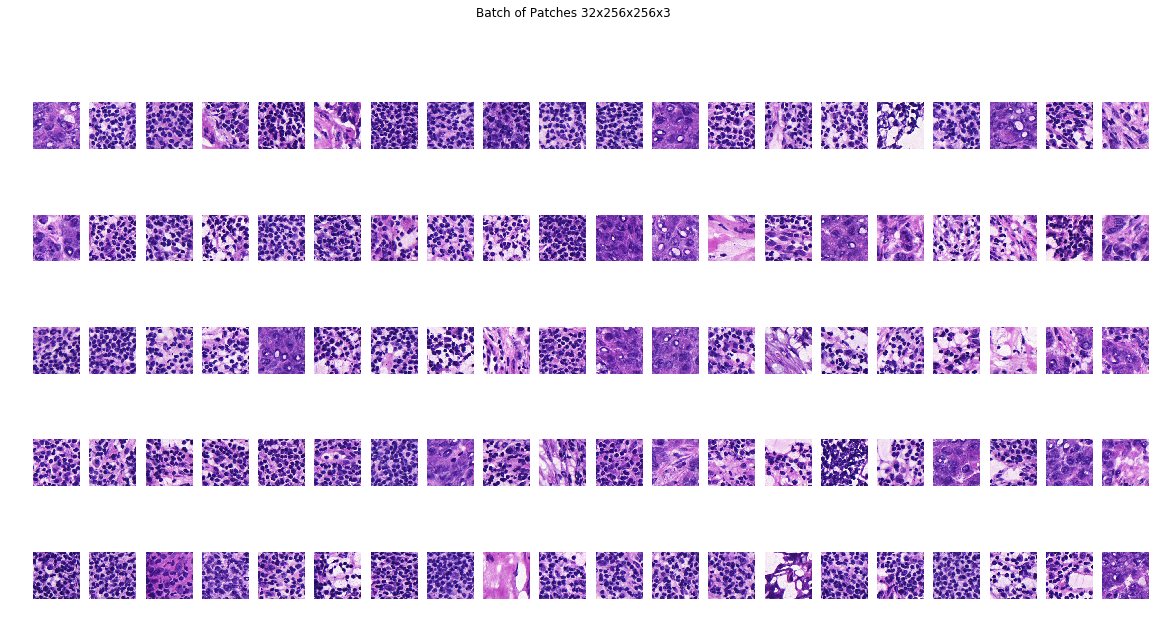

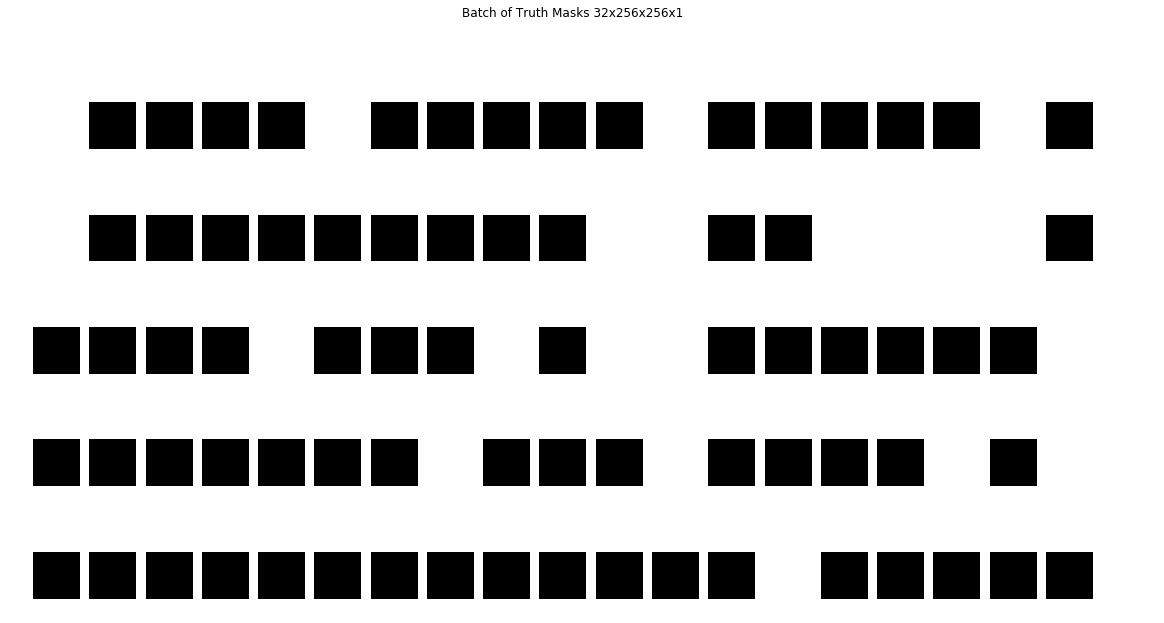

In [19]:
f, axes = plt.subplots(5,20, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_X[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(5, 20, figsize=(20, 10));
ax = axes.flatten()    
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');

- mask 된 부분 약간 이상했음
- mask 가 확실히 흰색인 부분만 학습세트로 써야겠다고 결정
- 혹은 그 mask를 조절해서 원본과 맞춰야함 - 그러기 위해서, deepzoom, read_region, get_thumbnail 다시 다 확인해야함

## 위의 문제 사항 해결완료  

- slide properties 이용해서 min offset 구하기
- get.thumbnail에 소수 이용 가능
- OpenslideTest.ipynb 파일에서 확인할 수 있음

# 1-5. Data Augmentation

---
(camelyon17)
- convert images to horizontal flip
- convert images to vertical flip
- convert images to gray scale randomly (percentage = 10%)
- convert images brightness, contrast, saturation, hue slightly

---
(camelyon16 -google)
- 4 multiples of 90˚ rotations. + left-right flip (8 orientations)
- perturb color : (maximum delta)
  - brighteness 64/255,
  - saturation 0.25,
  - hue 0.04
  - contrast 0.75 
- Jitter : up to 8 pixels.
(- pixel values clipped [0,1], and scaled [-1,1])
---

# 1-6. Sampling

---
(google)
- 먼저 'normal'과 'tumor'를 같은 확률로 뽑고
- 그 라벨의 패치들을 가지고 있는 슬라이드를 랜덤하게 뽑고 (훈련중에 나타나는 패치수들을 한정적으로 만들지 않기 위해) 
- 그 슬라이드들에서 패치들을 샘플링한다.
---
(구현)
- 샘플링 전 데이터 분포 확인 필요
- min slide 몇개 뽑았을 때 원하는 sample size 나오는지 계산
- 


# 2. NetWork

In [20]:
- U net 구조(지금) #base network도 하나 만들고
- Inception V3 (parameter 수 적은 걸로)
- ResNet

SyntaxError: invalid syntax (<ipython-input-20-952d84b4bc5e>, line 1)

In [21]:
patch_size = 256

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', 
                        input_shape=(patch_size, patch_size, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2DTranspose(64, 3, strides=[2, 2], padding='same', activation='relu'))
model.add(layers.Conv2DTranspose(32, 3, strides=[2, 2], padding='same', activation='relu'))
model.add(layers.Conv2DTranspose(2, 3, strides=[2, 2], padding='same', activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 64)        73792     
__________

# 3. Train

In [23]:
BATCH_SIZE = 50
N_EPOCHS = 10

NUM_SAMPLES = 10000

In [24]:
samples = find_patches_from_slide(slide_path)
samples = samples.sample(NUM_SAMPLES, random_state=42)
samples.reset_index(drop=True, inplace=True)

In [25]:
samples.is_tumor.value_counts()

False    7105
True     2895
Name: is_tumor, dtype: int64

In [26]:
len(samples)

10000

In [27]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(samples, samples["is_tumor"]):
        train_samples = samples.loc[train_index]
        validation_samples = samples.loc[test_index]

In [28]:
N_EPOCHS

10

In [29]:
## TODO Add checkpoint mechanism to save old model before generating new

train_generator = gen_imgs(train_samples, BATCH_SIZE)
validation_generator = gen_imgs(validation_samples, BATCH_SIZE)

# Train model
train_start_time = datetime.now()
history = model.fit_generator(train_generator, np.ceil(len(train_samples) / BATCH_SIZE),
    validation_data=validation_generator,
    validation_steps=np.ceil(len(validation_samples) / BATCH_SIZE),
    epochs=N_EPOCHS)
train_end_time = datetime.now()
print("Model training time: %.1f minutes" % ((train_end_time - train_start_time).seconds / 60,))

Epoch 1/10
 45/180 [======>.......................] - ETA: 2:20 - loss: 0.5404 - acc: 0.7026

KeyboardInterrupt: 

In [ ]:
# Save model
model = models.load_model('../model/model0121_2.h5')

In [ ]:
model.summary()

# 4. Evaluate

In [215]:
# 4-1. Visualization A single patches prediction

In [46]:
def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction

def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: prediction: 256x256x1, per-pixel tumor probability
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = cv2.cvtColor(patch, code=cv2.COLOR_RGB2GRAY)
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='jet', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='jet', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')

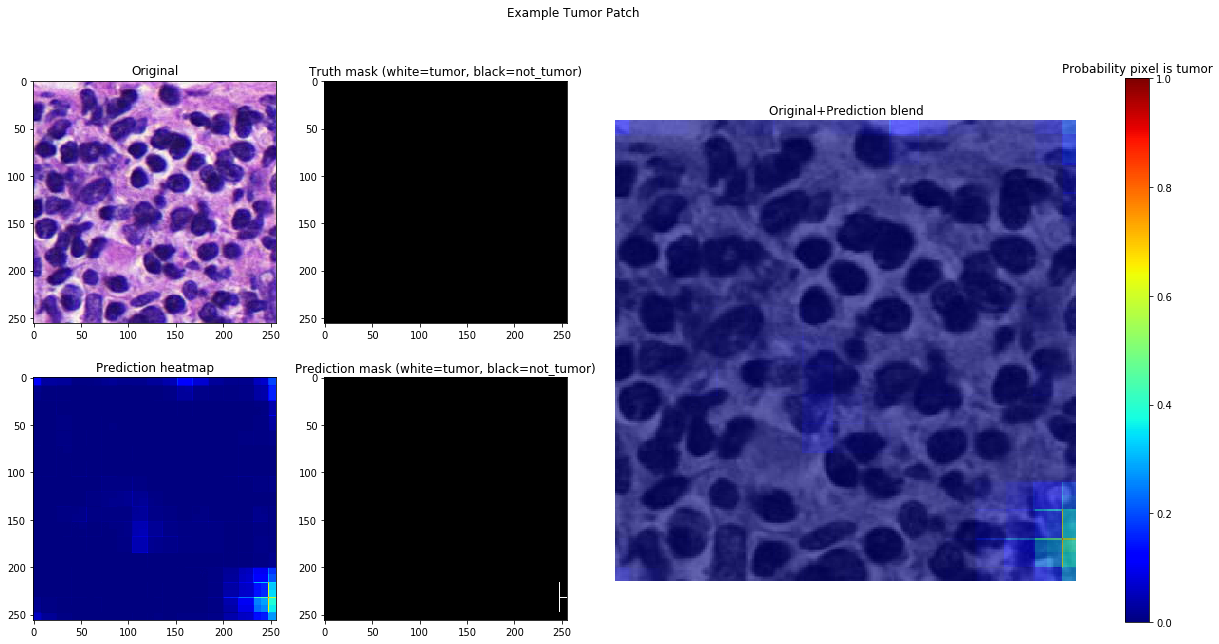

In [63]:
# 3 , 5(0.91) , 8(완전잘못) , 13(0.88) , 16(0.87) 32, 37
example_patch = example_X[49]
example_truth = example_y[49]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

# 4-3. AUC 계산

- 256 x 256 prediction ; AUC : .983
- 128 x 128 prediction ; AUC : .984

In [ ]:
from sklearn import metrics

In [221]:
start_x = PATCH_SIZE//4
start_y = PATCH_SIZE//4
pred_size = PATCH_SIZE//2

In [222]:
labels= []
preds = []
for i in range(len(example_y)):
    label = np.max(example_y[i].argmax(axis=2))
    labels.append(label)
    prediction = predict_from_model(example_X[i], model)
    pred_X = np.zeros((pred_size,pred_size))
    for x in range(start_x,start_x+pred_size):
        for y in range(start_y, start_y+pred_size):
            pred_X[x-start_x][y-start_y] = prediction[x][y]
    pred_s = pd.Series(pred_X.flatten())
    pred_x_i = np.max(pred_s)
    preds.append(pred_x_i)

In [223]:
# 128,128 으로 예측했을때
y = np.asarray(labels)
pred = np.asarray(preds)
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)

0.9844074844074844

In [ ]:
# y = np.asarray(labels)
# pred = np.asarray(preds)
# # 256, 256 으로 예측했을때
# fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
# metrics.auc(fpr, tpr)
# # 0.9838877338877339

# visual

In [211]:
example_patch = example_X[3]
example_truth = example_y[3]
Y = example_truth
small_Y =np.zeros((pred_size,pred_size,2))
for x in range(start_x,pred_size):
    for y in range(start_y, pred_size):
        small_Y[x-start_x][y-start_y][0] = Y[x][y][0]
        small_Y[x-start_x][y-start_y][1] = Y[x][y][1]

In [212]:
for i in range(len(example_y)):
    prediction = predict_from_model(example_patch, model)
    pred_X = np.zeros((pred_size,pred_size))
    for x in range(start_x,start_x+pred_size):
        for y in range(start_y, start_y+pred_size):
            pred_X[x-start_x][y-start_y] = prediction[x][y]

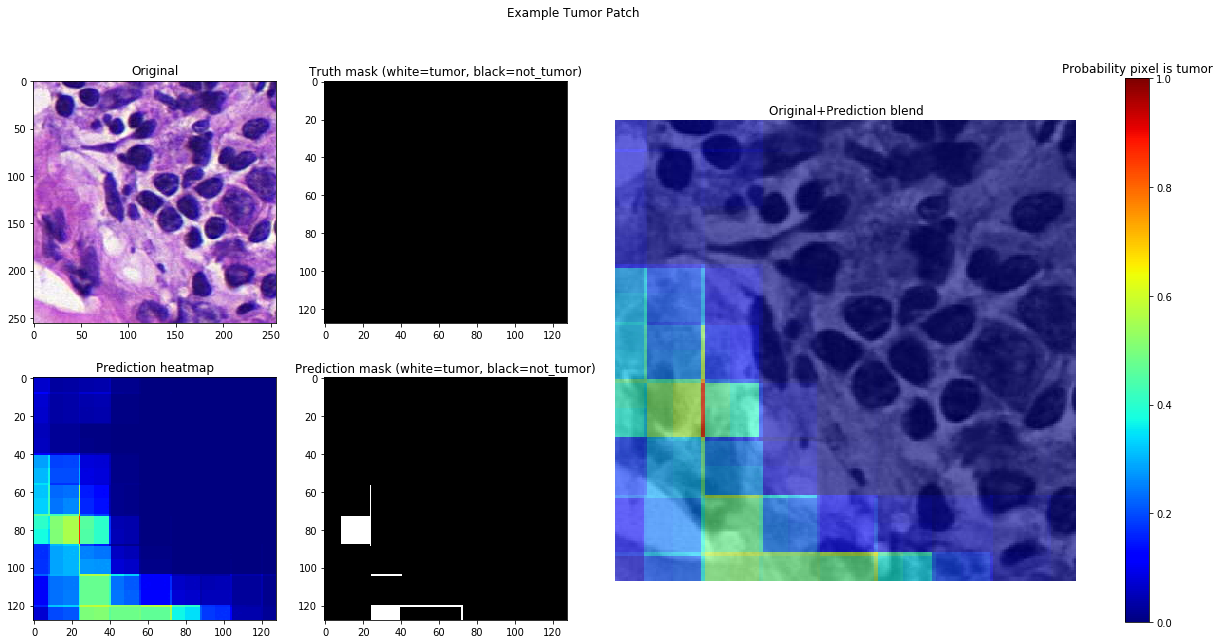

In [213]:
plot_patch_with_pred(example_patch, small_Y, pred_X, title_str='Example Tumor Patch')

In [155]:
predict_max_one[0:10] #3
predict_max_one[10:20]
predict_max_one[20:30] #26
predict_max_one[30:40] #33
predict_max_one[40:50] #42 45
predict_max_one[50:60] #52,53,57
predict_max_one[60:70] #69
predict_max_one[70:80] #72, 75
predict_max_one[80:90] #82
predict_max_one[90:100] #93(positive인데)


,pred,label
90,0.923311,0
91,0.429585,0
92,0.738287,0
93,0.912161,1
94,0.029885,0
95,0.285305,0
96,0.067436,0
97,0.522422,0
98,0.129458,0
99,1.000000,1


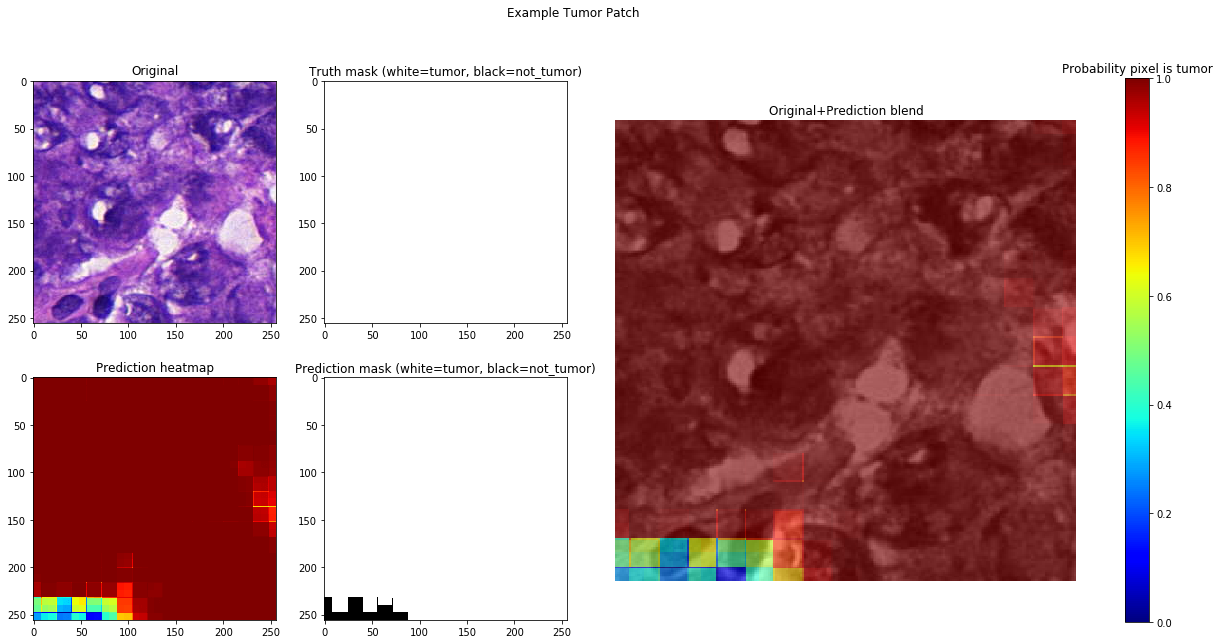

In [158]:
# 3 , 5(0.91) , 8(완전잘못) , 13(0.88) , 16(0.87) 32, 37
example_patch = example_X[99]
example_truth = example_y[99]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

count    65536.000000
mean         0.011505
std          0.038305
min          0.000024
25%          0.001093
50%          0.002338
75%          0.005775
max          0.791444
dtype: float64


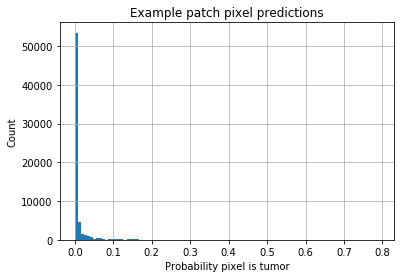

In [57]:
pred_s = pd.Series(prediction.flatten())
print(pred_s.describe())
ax = pred_s.hist(bins=100);
ax.set_title('Example patch pixel predictions');
ax.set_ylabel('Count');
ax.set_xlabel('Probability pixel is tumor');

# 4-2. Performance Metrics

In [ ]:
# threshold = 0.9 로 바꿔보자

In [47]:
def predict_batch_from_model(patches, model):
    """Predict which pixels are tumor.
    
    input: patch: `batch_size`x256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    predictions = model.predict(patches)
    predictions = predictions[:, :, :, 1]
    return predictions

In [52]:
validation_generator = gen_imgs(validation_samples, BATCH_SIZE)
validation_steps = np.ceil(len(validation_samples) / BATCH_SIZE)

confusion_mtx = np.zeros((2, 2))

for i in tqdm(range(int(validation_steps))):
    X, y  = next(validation_generator)
    preds = predict_batch_from_model(X, model)
    
    y_true = y[:, :, :, 1].ravel()
    y_pred = np.uint8(preds > 0.5).ravel()
    
    confusion_mtx += confusion_matrix(y_true, y_pred, labels=[0, 1])

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


  5%|████▏                                                                              | 1/20 [00:10<03:15, 10.27s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 10%|████████▎                                                                          | 2/20 [00:19<03:01, 10.11s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 15%|████████████▍                                                                      | 3/20 [00:29<02:49,  9.99s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 20%|████████████████▌                                                                  | 4/20 [00:39<02:38,  9.91s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 25%|████████████████████▊                                                              | 5/20 [00:49<02:27,  9.85s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 30%|████████████████████████▉                                                          | 6/20 [00:58<02:17,  9.82s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 35%|█████████████████████████████                                                      | 7/20 [01:08<02:07,  9.77s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 40%|█████████████████████████████████▏                                                 | 8/20 [01:18<01:57,  9.76s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 45%|█████████████████████████████████████▎                                             | 9/20 [01:28<01:47,  9.75s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 50%|█████████████████████████████████████████                                         | 10/20 [01:37<01:37,  9.74s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 55%|█████████████████████████████████████████████                                     | 11/20 [01:47<01:27,  9.73s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 60%|█████████████████████████████████████████████████▏                                | 12/20 [01:57<01:17,  9.74s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:07<01:08,  9.77s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:17<00:59,  9.87s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [02:26<00:49,  9.84s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [02:36<00:39,  9.86s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [02:46<00:29,  9.84s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [02:56<00:19,  9.89s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [03:06<00:09,  9.94s/it]

x_train_shape : (50, 256, 256, 3)
y_train_shape :  (50, 256, 256, 2)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:16<00:00,  9.92s/it]


In [53]:
confusion_mtx

array([[45382287.,  1213297.],
       [ 2249556., 16690860.]])

In [54]:
tn = confusion_mtx[0, 0]
fp = confusion_mtx[0, 1]
fn = confusion_mtx[1, 0]
tp = confusion_mtx[1, 1]

In [55]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Accuracy: %.2f" % accuracy)
print("Recall: %.2f" % recall)
print("Precision: %.2f" % precision)
print("F1 Score: %.2f" % f1_score)

Accuracy: 0.95
Recall: 0.88
Precision: 0.93
F1 Score: 0.91


# GPU 

- https://3months.tistory.com/206

In [381]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import keras.backend.tensorflow_backend as K

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9972183459035603206
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2218013491
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15425068927370114637
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [384]:
import keras.backend.tensorflow_backend as K